In [16]:
import numpy as np
import pandas as pd
import glob, os
import itertools
import matplotlib.image as mpimg
import cv2
import pickle

import classifier

%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
excluded_vids = [
'590139186',
'590657619',
'591530556',
'591548409',
'593958477',
'597324934',
'598259237',
'601904995',
'602457895',
'603783558',
'604185957',
'604277316',
'604840355',
'604984888',
'605089435',
'605439829',
'605938143',
'607462495',
'612563393',
'612685857',
'190011',
'190306',
'190406',
'190925',
'190943',
'191676',
'193810',
'194058',
'194487',
'194875',
'195446',
'195809',
]

import re
vids = [re.search('(\d+).mp4', v).group(1) for v in sorted(glob.glob('/data1/yolo/validation/videos1/failed/*.mp4'))]
vids += [re.search('(\d+).mp4', v).group(1) for v in sorted(glob.glob('/data1/yolo/validation/videos2/failed/*.mp4'))]
# vids = [v for v in vids if v not in excluded_vids]

failure_starts = pd.read_csv('failure_starts.csv', index_col=0, names=['start'])

In [18]:
#Hyperparameters that may need tweakings
THRESH = 0.25
EWM_SPAN = 20
ROLLING_THRESH = 0.1
# PCA_STD_THRESH = 1.5
INIT_GOOD_FRAMES = 50//4 #50
OUTLIER_THRESH = 0.1
MIN_PCA_OBSV = 12//4 # 12
LOOK_BACK = 120//4 # 120 # the frames that we look back to determine if there are sufficient outliers

In [19]:
all_detections = pickle.load( open( "/tmp/all_detections.pkl", "rb" ) )

def load_detections(vid):
    dets = [{"index": int(d[0][-9:-4]), "detections": d[1], "file": d[0]}  for d in all_detections if "/{}-".format(vid) in d[0]]
    df = pd.DataFrame(dets)
    df['accu_detection'] = df.detections.apply(accu_detection)
    df['rolling_ewm'] = df.accu_detection.ewm(span=20).mean()
    return df.set_index("index")

In [20]:
def max_detection(detections):
    if len(detections) == 0:
        return 0
    return max([d[1] for d in detections])

def accu_detection(detections):
    return sum([d[1] for d in detections])

In [21]:
def video_fp_fn(vids, failure_starts, v_thresh, plot=False):
    if plot:
        plt.style.use('ggplot')
        fig=plt.figure(figsize=(16, 16*40))

    fp = []
    fn = []

    for j, vid in enumerate(vids):
        det = load_detections(vid)
        failure_start = failure_starts.loc[int(vid)].start
        if plot:
            fig.add_subplot(len(vids)+1, 2, 2*j+1)
            plt.plot(det.accu_detection)
            plt.plot(det.rolling_ewm)
            plt.axvline(x=failure_start, color='b')

            fig.add_subplot(len(vids)+1, 2, 2*j+2)
            plt.text(0.6, 0.5, vid, size=20, ha="center", va="center",)

        detected_failures = det.index[det.rolling_ewm > v_thresh]
        if failure_start > 0:
            if len(detected_failures) == 0:
                fn += [vid]
            elif detected_failures[0] < failure_start:
                fp += [vid]
    return fp, fn

In [40]:
fp, fn = video_fp_fn(vids, failure_starts, ROLLING_THRESH)
len(fp)/283, len(fn)/283

(0.27208480565371024, 0.22968197879858657)

In [23]:
def pca_fit(detections):
    from functools import reduce
    detections = reduce(lambda x, y: x+y, detections)
    
#     print("%s detections to fit." % len(detections))
    if len(detections) < MIN_PCA_OBSV: # Minimum number of observations for PCA to make statistical sense
#         print("No sufficient observations. Skipping PCA")
        return None, None, None
    
    X = np.array([ [d[1]] + list(d[2]) for d in detections])
    X = np.hstack((X[:,0].reshape(X.shape[0], 1), (X[:,1] - X[:,3]/2).reshape(X.shape[0], 1), (X[:,2] - X[:,4]/2).reshape(X.shape[0], 1)))

    from sklearn.preprocessing import StandardScaler
    X_scaler = StandardScaler().fit(X)
    X_std = X_scaler.transform(X)

    from sklearn.decomposition import PCA as sklearnPCA
    sklearn_pca = sklearnPCA(n_components=2)
    pca_matrix = sklearn_pca.fit(X_std)
    Y_sklearn = pca_matrix.transform(X_std)

    Y_std = StandardScaler().fit(Y_sklearn).scale_
    
    return X_scaler, pca_matrix, Y_std

def pca_detect(new_detections, X_scaler, pca_matrix, Y_std, PCA_STD_THRESH):
    from functools import reduce
    new_detections = reduce(lambda x, y: x+y, new_detections[-1*LOOK_BACK:])
    
#     print("%s new detections." % len(new_detections))
    if len(new_detections) <= MIN_PCA_OBSV:
#         print(" Skipping for spike window")
        return False
    
    if not X_scaler:
#         print ("No PCA parameters. Assuming it's detected.")
        return True
    
    X = np.array([ [d[1]] + list(d[2]) for d in new_detections])
    X = np.hstack((X[:,0].reshape(X.shape[0], 1), (X[:,1] - X[:,3]/2).reshape(X.shape[0], 1), (X[:,2] - X[:,4]/2).reshape(X.shape[0], 1)))

    X_std = X_scaler.transform(X)
    Y_sklearn = pca_matrix.transform(X_std)
    num_outliers = np.count_nonzero((np.absolute(Y_sklearn) > PCA_STD_THRESH * Y_std).any(axis=1))
#     print("%s outliers." % num_outliers)
    return num_outliers > len(new_detections) * OUTLIER_THRESH

In [24]:
def video_perf(det_df, true_failure_start, PCA_STD_THRESH):
    rolling_p = det_df.accu_detection.ewm(span=EWM_SPAN).mean()
    detections = det_df.detections

    failure_start = -1
    false_alerts = []

    safe_until = INIT_GOOD_FRAMES
    X_scaler = pca_matrix = Y_std = None

    for i, p in enumerate(rolling_p.values):
        if i <= safe_until:
            continue

        if p > ROLLING_THRESH:
            if not X_scaler:
#                 print("init pca: %s" % i)
                X_scaler, pca_matrix, Y_std = pca_fit(detections[:safe_until+1])

            new_detections = detections[safe_until+1:i+1]
#             print("pca detecting: %s with (%s - %s - %s)" % (i, X_scaler, pca_matrix, Y_std))
            if pca_detect(new_detections, X_scaler, pca_matrix, Y_std, PCA_STD_THRESH):
#                 print("pca detected: %s" % i)
                if i < true_failure_start: # it's false positive
                    false_alerts += [i]
                    safe_until = i
                    X_scaler, pca_matrix, Y_std = pca_fit(detections[:safe_until+1])
                else:
                    if failure_start < 0:
                        failure_start = i
                        break

    return (true_failure_start, failure_start, false_alerts, det_df)

In [58]:
# results = [(vid_perf(vid), vid) for vid in [ v[48:57] for v in sorted(glob.glob("/home/ubuntu/mynotebooks/yolo/validation/videos/*.mp4"))]]

pr = []
for t in (np.logspace(0.01, 1, 15) - 1):
    results = []
    for j, vid in enumerate(vids):
        det = load_detections(vid)
        results += [(vid,) + video_perf(det, failure_starts.loc[int(vid)].start // 4, t)]
        
    df = pd.DataFrame(data=[r[:4] for r in results], columns=['vid', 't_s', 's', 'f_p'])
#     false_positives = np.sum(np.clip(df[df.apply(lambda x: len(x['f_p']) > 0, axis=1)].f_p.map(len), 0, 4))
    false_positives = df[df.f_p.apply(len) > 0].shape[0]/len(results)
    failed_detections = df[df.apply(lambda x: x['t_s'] > x['s'], axis=1)].shape[0]/len(results)
    pr += [(t, false_positives, failed_detections)]
    
with open('/tmp/pr_std.pkl', 'wb') as f:
    pickle.dump(pr, f)


,t,f_p,f_n,precision,recall
0,0.023293,0.215548,0.356890,0.784452,0.643110
1,0.204243,0.215548,0.356890,0.784452,0.643110
2,0.417192,0.215548,0.356890,0.784452,0.643110
3,0.667796,0.215548,0.356890,0.784452,0.643110
4,0.962715,0.215548,0.356890,0.784452,0.643110
5,1.309784,0.215548,0.356890,0.784452,0.643110
6,1.718227,0.215548,0.363958,0.784452,0.636042
7,2.198895,0.215548,0.385159,0.784452,0.614841
8,2.764561,0.208481,0.406360,0.791519,0.593640
9,3.430253,0.204947,0.413428,0.795053,0.586572


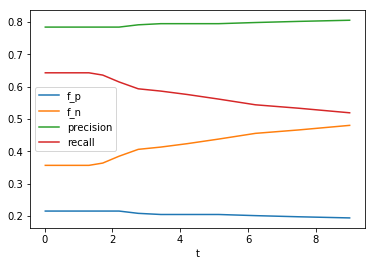

In [59]:

df = pd.DataFrame.from_records(pr, columns=['t', 'f_p', 'f_n'])
df['precision'] = 1 - df.f_p
df['recall'] = 1 - df.f_n
# pd.concat((df, 2*(df['precision']*df['recall'])/(df['precision'] + df['recall'])), axis=1)[['precision', 'recall', 0]][10:].plot()
df.set_index('t').plot()
df